# Exploring Einsum Networks (Einet) on MNIST

In this tutorial, we'll explore how to use Einsum Networks (Einet) for various tasks with the MNIST dataset. Einsum Networks are a type of probabilistic model that can learn complex distributions over high-dimensional spaces. We'll cover the following topics:

- Loading and visualizing the MNIST dataset
- Setting up an Einet model
- Training the model on the MNIST dataset
- Evaluating the model's performance
- Sampling new images from the trained model
- Calculating the most probable explanation (MPE) for data samples
- Reconstructing images with missing pixels

Let's begin by setting up our environment and loading the MNIST dataset.


## Data Preparation and Visualization

Before we dive into the Einsum Network, we need to load and prepare the MNIST dataset. We'll also visualize some of the handwritten digit images to understand what kind of data we're working with. The following code cells will handle the data loading and display a batch of image samples.


Using bfloat16 Automatic Mixed Precision (AMP)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


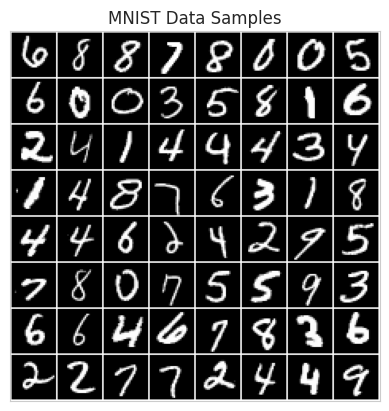

In [89]:
%load_ext autoreload
%autoreload 2

import seaborn as sns
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
from matplotlib import pyplot as plt
import numpy as np
import tqdm

import lightning as L

devices = [0]
fabric = L.Fabric(accelerator="auto", devices=devices, precision="bf16-mixed", strategy="auto")
fabric.launch()

sns.set_style("whitegrid")
torch.manual_seed(0)
np.random.seed(0)

# Number of bits used to represent each pixel
n_bits = 8
reduce_bits = lambda x: torch.floor((x * (2**8 - 1)) / (2 ** (8 - n_bits))).int()

# Load data
image_size = 28
transform = transforms.Compose(
    [transforms.Resize(size=(image_size, image_size)), transforms.ToTensor(), transforms.Lambda(reduce_bits)]
)
dataset_train = MNIST(root="~/data", download=True, train=True, transform=transform)
dataset_test = MNIST(root="~/data", download=True, train=False, transform=transform)

# Make dataloader
batch_size = 512
dataloader_train = DataLoader(dataset_train, shuffle=True, batch_size=batch_size, num_workers=8)
dataloader_test = DataLoader(dataset_test, shuffle=False, batch_size=batch_size, num_workers=8)
dataloader_train, dataloader_test = fabric.setup_dataloaders(dataloader_train, dataloader_test)


def plot_images(images: torch.Tensor, nrow=16, title=None):
    """Plot images in a grid of nrow rows."""
    grid = torchvision.utils.make_grid(
        images.float(),
        nrow=nrow,
        normalize=True,
        padding=1,
        pad_value=1.0,
    )
    plt.figure()
    plt.title(title)
    plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.show()


# Plot some mnist samples with matplotlib
images = next(iter(dataloader_train))[0][:64]
plot_images(images, nrow=8, title="MNIST Data Samples")

## Einet Model Configuration

Now, let's configure our Einet model. We will define its architecture, including the depth, number of sums, and other parameters. We'll also set up the training components, such as the optimizer and learning rate scheduler. Once configured, we'll initialize the model and prepare it for training on the MNIST dataset.


In [90]:
import torch

import sys

sys.path.append("../")
from simple_einet.einet import EinetConfig, Einet
from simple_einet.layers.distributions.binomial import Binomial

# Configure model
cfg = EinetConfig(
    num_features=image_size**2,
    num_channels=1,
    depth=3,
    num_sums=20,
    num_leaves=20,
    num_repetitions=20,
    num_classes=1,
    leaf_type=Binomial,
    leaf_kwargs={"total_count": 2**n_bits - 1},
    layer_type="einsum",
    dropout=0.0,
)
model = Einet(cfg)

# Setup optimizer and learning rate scheduler
lr = 0.1
epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(
    milestones=[int(epochs * 0.7), int(epochs * 0.9)], optimizer=optimizer, gamma=0.5
)
model, optimizer = fabric.setup(model, optimizer)
model.train()


print(model)
print("Number of parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

_FabricModule(
  (_forward_module): Einet(
    EinetConfig(num_features=784, num_channels=1, num_sums=20, num_leaves=20, num_repetitions=20, num_classes=1, depth=3, dropout=0.0, leaf_type=<class 'simple_einet.layers.distributions.binomial.Binomial'>, leaf_kwargs={'total_count': 255}, layer_type='einsum')
    (leaf): FactorizedLeaf(
      num_features=784, num_features_out=8
      (base_leaf): Binomial(num_features=784, num_leaves=20, out_shape=(N, 784, 20))
    )
    (layers): ModuleList(
      (0): EinsumLayer(num_features=8, num_sums_in=20, num_sums_out=20, out_shape=(N, 4, 20, 20), weight_shape=(4, 20, 20, 20, 20))
      (1): EinsumLayer(num_features=4, num_sums_in=20, num_sums_out=20, out_shape=(N, 2, 20, 20), weight_shape=(2, 20, 20, 20, 20))
      (2): EinsumLayer(num_features=2, num_sums_in=20, num_sums_out=1, out_shape=(N, 1, 1, 20), weight_shape=(1, 1, 20, 20, 20))
    )
    (mixing): MixingLayer(num_features=1, num_sums_in=20, num_sums_out=1)
  )
  (_original_module): Einet(


## Model Evaluation Function

To assess the performance of our Einet model, we'll define an evaluation function. This function will compute the negative log-likelihood (NLL) loss over the dataset provided. The NLL is a measure of how well the probability distribution represented by the model aligns with the actual data (i.e., how likely is the data, given the model).


In [91]:
def test(model: "Union[Einet, EinetMixture]", loader: DataLoader, num_batches=None):
    """
    Evaluate model on a dataset.

    Args:
        model: Einet model to evaluate.
        loader: DataLoader for the dataset to evaluate on.
        num_batches: Number of batches to evaluate on. If None, evaluate on the entire dataset.

    Returns:
        Negative log-likelihood loss averaged over the dataset.
    """
    model.eval()
    loss = 0.0

    if num_batches is None:
        num_batches = len(loader)

    # Evaluate nll on all samples
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(loader):
            log_likelihood = model(data)
            loss += -1 * log_likelihood.sum()

            if batch_idx + 1 >= num_batches:
                break

    model.train()
    # Average over all samples
    return loss / (num_batches * loader.batch_size)

## Training the Model

With our model configured, we can proceed to train it using the MNIST data. We'll perform multiple epochs of training and evaluate the model on both the training and test datasets after each epoch. The training process includes calculating the log-likelihood, computing the NLL loss, and updating the model parameters using gradient descent.


In [92]:
# Collect train/test dataset losses for visualization
loss_train = []
loss_test = []

for epoch in tqdm.trange(epochs, desc="Training"):  # Training loop
    for data, _ in dataloader_train:
        optimizer.zero_grad()  # Reset gradients
        log_likelihood = model(data)  # Forward pass to obtain log likelihoods
        nll = -1 * log_likelihood.mean()  # Compute mean negative log likehood as loss function
        fabric.backward(nll)  # Backpropagate gradients
        optimizer.step()  # Update weights

    # Update learning rate
    lr_scheduler.step()

    # Evaluate model after every epoch
    loss_train += [test(model, dataloader_train, num_batches=10)]
    loss_test += [test(model, dataloader_test, num_batches=10)]

Training: 100%|██████████████████████████████████████████████████████████████████████| 10/10 [00:59<00:00,  5.98s/it]


## Training Progress Visualization

It's essential to track the model's performance over time. We'll use matplotlib and seaborn to plot the negative log-likelihood loss over the training epochs for both the training and test datasets. This visualization will help us understand how the model is learning and if it's improving as expected over time.


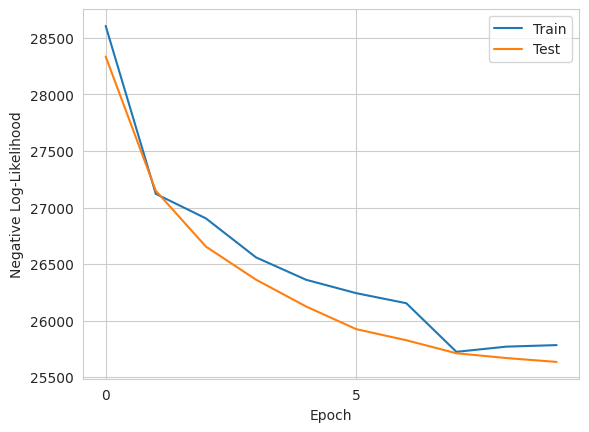

In [93]:
# Visualize training progress with matplotlib and seaborn
import matplotlib.pyplot as plt

plt.figure()
plt.plot(torch.stack(loss_train).cpu(), label="Train")
plt.plot(torch.stack(loss_test).cpu(), label="Test")
plt.xlabel("Epoch")
plt.ylabel("Negative Log-Likelihood")
plt.xticks(range(0, epochs, 5), labels=range(0, epochs, 5))
plt.legend()
plt.show()

## Sampling New Images from the Model

After training the model, we can sample new images from the learned distribution. These samples are generated from the model's learned representation of the MNIST digit distribution. We'll normalize the samples and visualize them to see the diversity and quality of the digits the model generates.


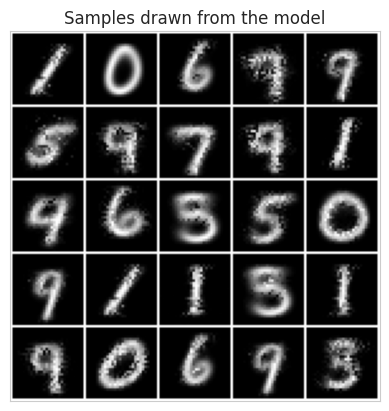

In [94]:
# Sample from model
samples = model.sample(num_samples=25, seed=0, mpe_at_leaves=True).float()

# Normalize each sample to [0, 1]
samples = samples - samples.min(2, keepdim=True)[0]
samples = samples / samples.max(2, keepdim=True)[0]
samples = samples.view(-1, 1, image_size, image_size)

plot_images(samples, nrow=5, title="Samples drawn from the model")

## Most Probable Explanation (MPE)

The Most Probable Explanation (MPE) is a concept in probabilistic graphical models where we find the most likely configuration of some variables given evidence. Here, we'll use the trained model to calculate the MPE for our dataset with an empty evidence set, which can serve as a mode of the distribution.


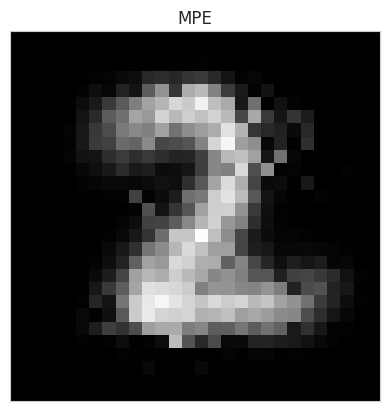

In [95]:
# Get most probable explanation (MPE)
mpe = model.mpe()
mpe = mpe.view(-1, 1, image_size, image_size)

plot_images(mpe, nrow=1, title="MPE")

## Reconstructing Images with Missing Pixels

A powerful application of Einsum Networks is the ability to reconstruct images with missing pixels. We'll simulate missing data by removing pixels from MNIST test images and then use our trained model to reconstruct the original images. This demonstrates the model's ability to infer missing information based on its learned distribution.


tensor(0.) tensor(255.)


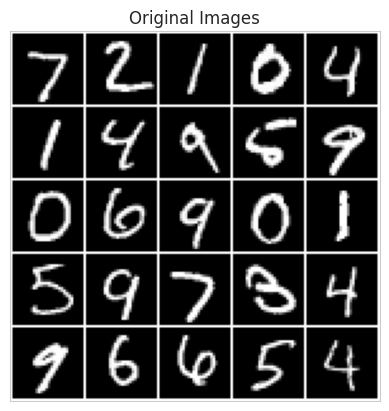

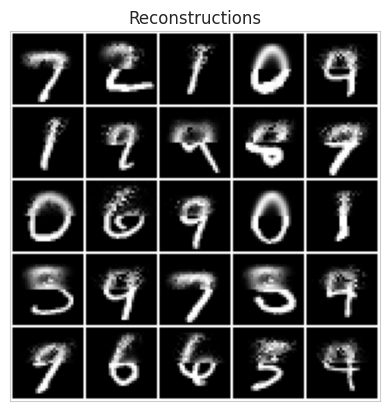

In [96]:
import numpy as np

# Construct indices for marginalized scopes (top-half of the image)
image_scope = np.array(range(image_size**2)).reshape(1, image_size, image_size)
marginalized_scopes = list(image_scope[:, round(image_size / 4 * 0) : round(image_size / 4 * 2), :].reshape(-1))

# Get some groundtruth data from the test set
test_x = next(iter(dataloader_test))[0][:25]
test_x = test_x.view(-1, 1, image_size**2)

# Remove pixels
test_x_marginalized = test_x.clone()
test_x_marginalized[..., marginalized_scopes] = 0.0

# Perform MPE reconstruction on the evidence
recs = model.mpe(evidence=test_x_marginalized, marginalized_scopes=marginalized_scopes).float().cpu()
recs = recs.view(-1, 1, image_size * image_size)
recs[..., marginalized_scopes] = recs[..., marginalized_scopes] - recs[..., marginalized_scopes].min(2, keepdim=True)[0]
recs[..., marginalized_scopes] = (
    recs[..., marginalized_scopes] / recs[..., marginalized_scopes].max(2, keepdim=True)[0] * (2**n_bits - 1)
)

test_x = test_x.view(-1, 1, image_size, image_size)
test_x_marginalized = test_x_marginalized.view(-1, 1, image_size, image_size)
recs = recs.view(-1, 1, image_size, image_size)

plot_images(test_x, nrow=5, title="Original Images")
plot_images(recs, nrow=5, title="Reconstructions")